# Exercise 04b: Inertial oscillations excited by a moving strom

**Due:** _12 January 2021_

**Names:** Mariana, Linus, Lukas, David

Consider that there is a storm in the atmosphere which is moving northward at a speed of $v_s$. The horizontal pressure structure of the storm is

$$p=-p_0 e^{-(\frac{r}{L})^2}$$

where $r$ is distance from the centre $(x=0,y=y_0+v_s t)$ of the storm, hence $r^2=x^2+(y-y_0-v_s t)^2$.
And the atmosphere motion driven by the storm is governed by the inertial oscillation equation

$$\frac{\partial q}{\partial t} + ifq = X,$$

where $q=u+iv$, $i=\sqrt{-1}$ and $X=-(\frac{\partial p}{\partial x} + i\frac{\partial p}{\partial y})$. Initially, the atmospheric motion is in geostrophic balance with the pressure perturbation associated with the storm, e.g. $ifq=X$ at $t=0$. The initial position of the storm is $y_0=-500km$ and its northward speed is $v_s=10km/h$.

Take $f=10^{-4} s^{-1}$, $p_0=2hPa$, $L=100km$, $\Delta x = \Delta y = 25km$ and $\Delta t=100s, 2000s$. Solve the equation numerically in the range $-1000km \leq x \leq 1000km$ and $-1000km \leq y \leq 1000km$. Justify your choice of time stepping scheme. Note that you have an analytical expression for the pressure perturbation associated with the storm, so you do to have to discretize the expression for $X$ but you shall use the exact value.

Plot pressure $p$ and $u,v$ when the storm is $-500km$, $-250km$, $0km$, $250km$ and $500km$ with respect to origin in the y-axis. Think about how to best present what is going on and try to explain the asymmetry in the response with respect to the track of the storm.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

In [12]:
class Stormtrack:
    def __init__(self, params = None):
        if params is None:
            params  = {'f': 0.0001, 'p_0': 200., 'L': 100e3, 'dxy': 25e3, 'y_0': -500e3, 'v_s': 10/3.6}
        self.f      = params['f']                               #s⁻¹
        self.p_0    = params['p_0']                             #Pa 
        self.L      = params['L']                               #m
        self.dxy    = params['dxy']                             #m
        self.y_0    = params['y_0']                             #m
        self.v_s    = params['v_s']                             #m s⁻¹
        self.grid()
    
    def grid(self):
        self.grid_x  = np.arange(-1000e3,1000e3+self.dxy,self.dxy)   
        self.grid_y  = np.arange(-1000e3,1000e3+self.dxy,self.dxy)
        self.mesh_x, self.mesh_y = np.meshgrid(self.grid_x, self.grid_y)

    def X(self, x, y, t):
        return((x+y*1j-(self.y_0+self.v_s*t)*1j)*2*self.Pressure(x,y,t)/self.L**2)
    
    def Pressure(self, x, y, t):
        return(-self.p_0*np.exp(-(x**2+(y-(self.y_0+self.v_s*t))**2)/self.L**2))
    
    def leap_frog(self,dt,output=[-500e3,-250e3,0,250e3,500e3]):
        self.dt = dt
        self.output = output
        self.t_out = (np.array(self.output)-self.y_0)/self.v_s
        q_0 = self.X(self.mesh_x,self.mesh_y,0)/(self.f*1j)  
        #q_1 = np.copy(q_0)                                                       #explicit euler
        q_1 = (self.X(self.mesh_x,self.mesh_y,self.dt)+q_0)/(1+self.dt*self.f*1j) #implicit Euler for first step
        self.t = np.arange(0,self.t_out[-1],self.dt)
        self.q_out = [q_0]
        self.p_out = [self.Pressure(self.mesh_x,self.mesh_y,0)]
        q = [q_0,q_1]
        for time in self.t[1:]:
            q_next = q[0]+2*self.dt*(self.X(self.mesh_x,self.mesh_y,time)-q[1]*self.f*1j)
            if time+self.dt in self.t_out:
                self.q_out.append(q_next)
                self.p_out.append(self.Pressure(self.mesh_x, self.mesh_y, time+self.dt))
            q[0] = np.copy(q[1])
            q[1] = q_next
            
    def plot(self):
        self.plotmesh_x = self.mesh_x/1000.
        self.plotmesh_y = self.mesh_y/1000.
        for i in range(0,len(self.q_out)):
            ulim = np.max(abs(self.q_out[i].real))
            vlim = np.max(abs(self.q_out[i].imag))
            fig = plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            plt.pcolormesh(self.plotmesh_x, self.plotmesh_y, self.p_out[i], cmap='Greens_r', shading='auto')
            plt.xlabel('x in km')
            plt.ylabel('y in km')
            plt.colorbar(label='Pressure in Pa')
            
            plt.subplot(1,3,2)
            plt.pcolormesh(self.plotmesh_x, self.plotmesh_y, self.q_out[i].real, cmap='PuOr', shading='auto', vmin=-vlim, vmax=vlim)
            plt.xlabel('x in km')
            plt.ylabel('y in km')
            plt.colorbar(label='u in m/s')
            
            plt.subplot(1,3,3)
            plt.pcolormesh(self.plotmesh_x, self.plotmesh_y, self.q_out[i].imag, cmap='PuOr', shading='auto', vmin=-vlim, vmax=vlim)
            plt.xlabel('x in km')
            plt.ylabel('y in km')
            plt.colorbar(label='v in m/s')
            
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig.suptitle('Storm at y = ' + str(self.output[i]/1000.) + ' km', fontsize=12)
            
    def zonal_asymmetry(self):
        for i in range(0,len(self.q_out)):
            u_asym_mean = np.mean(self.q_out[i].real*(storm.mesh_x < 0), axis=1)-np.mean(self.q_out[i].real*(storm.mesh_x > 0), axis=1)
            v_asym_mean = np.mean(self.q_out[i].imag*(storm.mesh_x < 0), axis=1)-np.mean(self.q_out[i].imag*(storm.mesh_x > 0), axis=1)
            fig = plt.figure(figsize=(20,10))
            
            plt.subplot(1,2,1)
            plt.plot(u_asym_mean, self.grid_y/1000, color='midnightblue')
            plt.ylabel('y in km')
            plt.xlabel('Difference in zonal mean of u')
            
            plt.subplot(1,2,2)
            plt.plot(v_asym_mean, self.grid_y/1000, color='darkred')
            plt.ylabel('y in km')
            plt.xlabel('Difference in zonal mean of v')
            
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig.suptitle('Storm at y = ' + str(self.output[i]/1000.) + ' km', fontsize=18)
            
    def plot_energy(self):
        self.plotmesh_x = self.mesh_x/1000.
        self.plotmesh_y = self.mesh_y/1000.
        for i in range(0,len(self.q_out)):
            ulim = np.max(abs(self.q_out[i].real))
            vlim = np.max(abs(self.q_out[i].imag))
            fig = plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            plt.pcolormesh(self.plotmesh_x, self.plotmesh_y, self.q_out[i].real**2+self.q_out[i].imag**2, cmap='Greens', shading='auto')
            plt.xlabel('x in km')
            plt.ylabel('y in km')
            plt.colorbar(label='Energy')
            
            
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig.suptitle('Storm at y = ' + str(self.output[i]/1000.) + ' km', fontsize=12)

In [13]:
storm = Stormtrack()

In [14]:
storm.leap_frog(100)

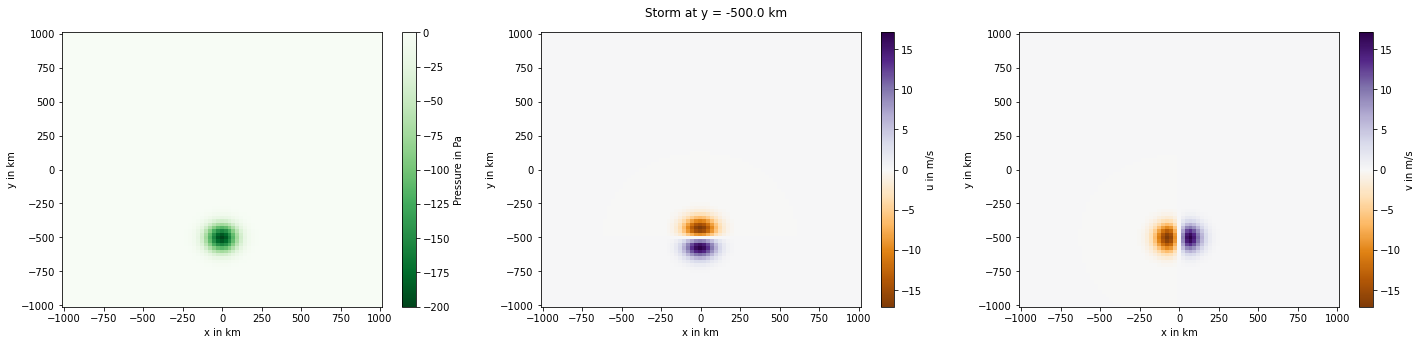

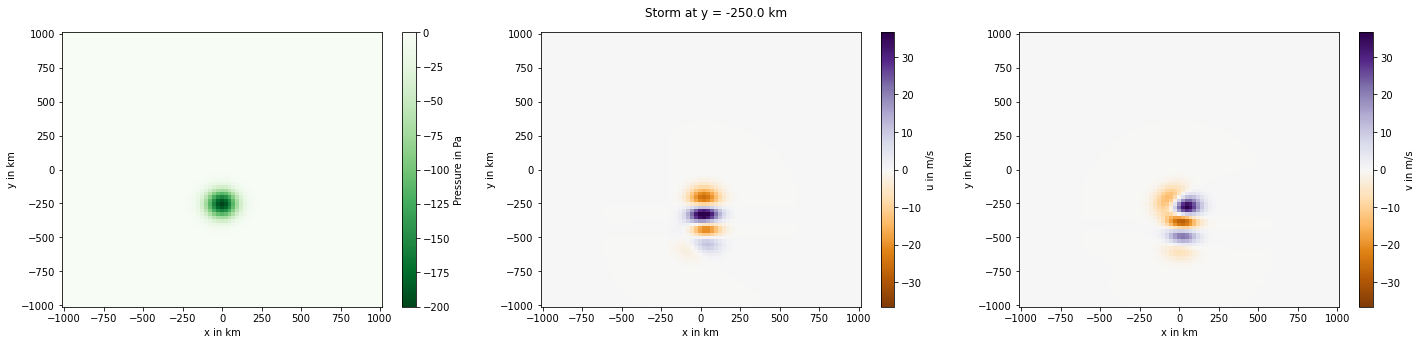

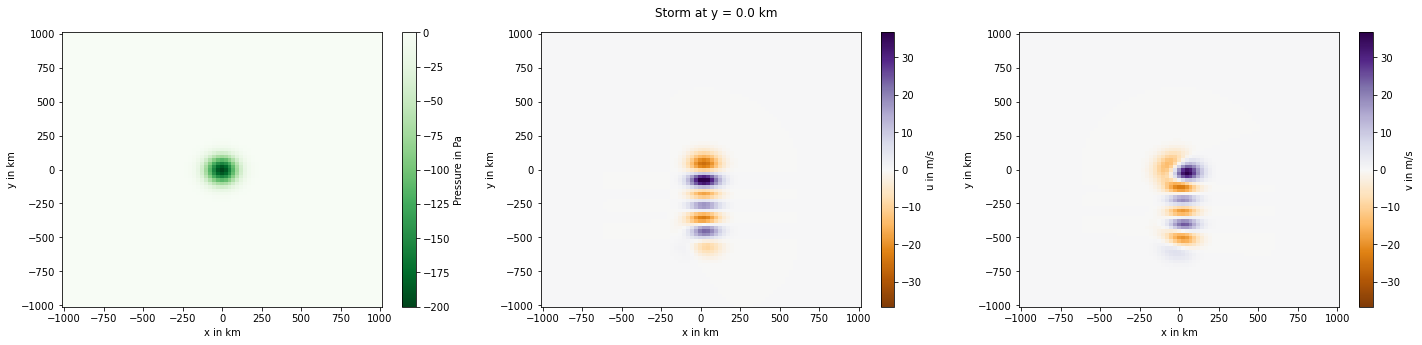

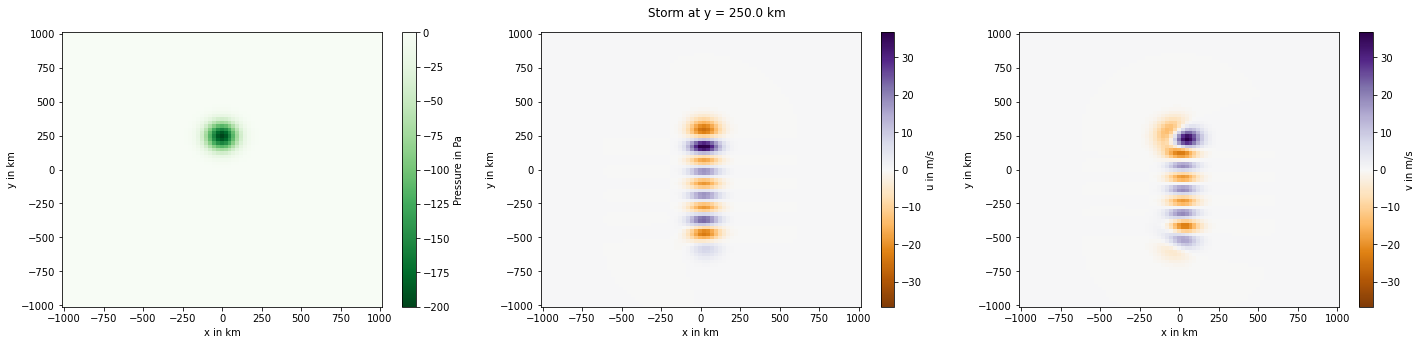

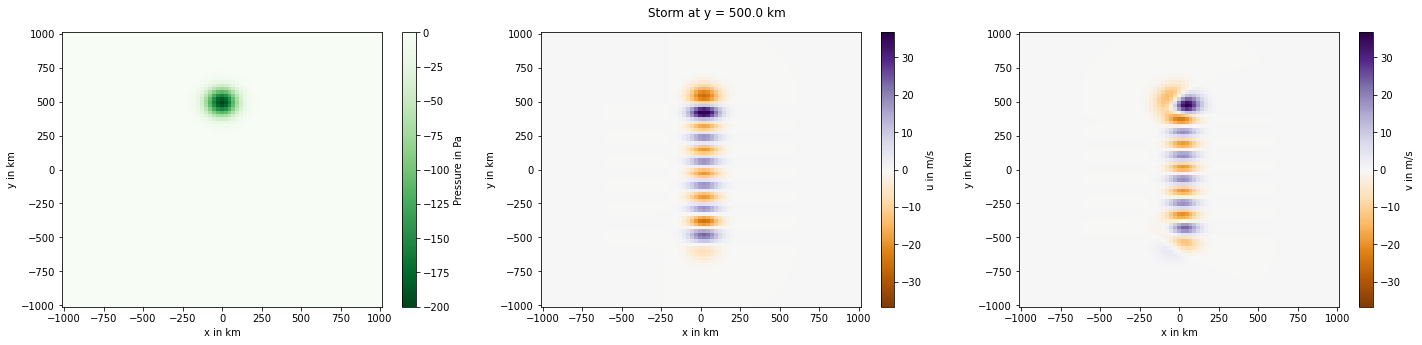

In [6]:
storm.plot()

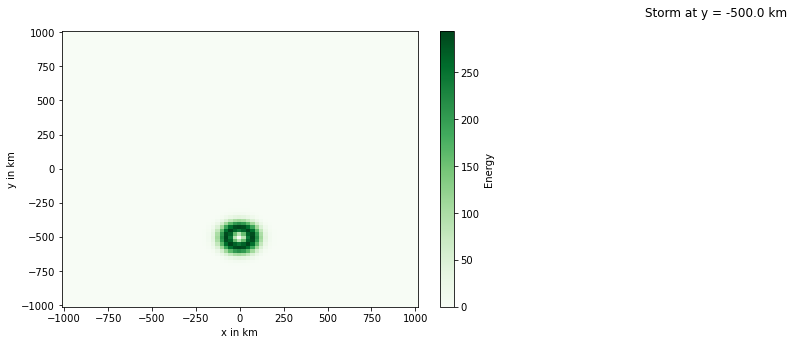

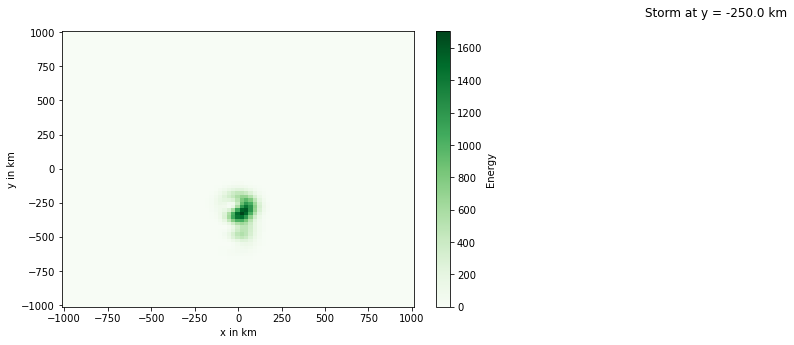

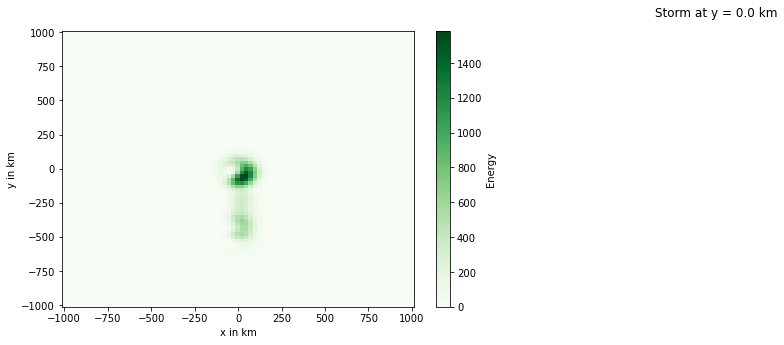

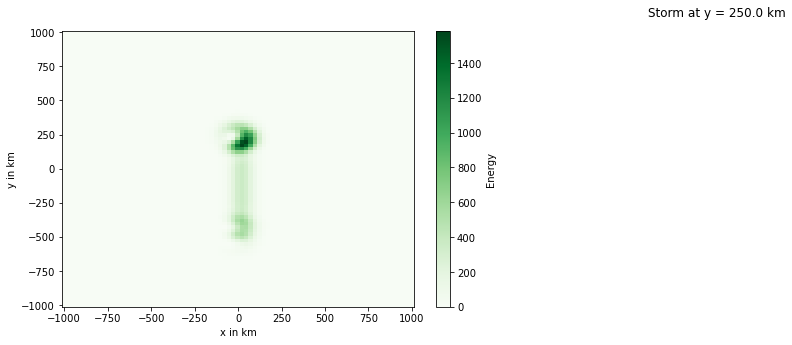

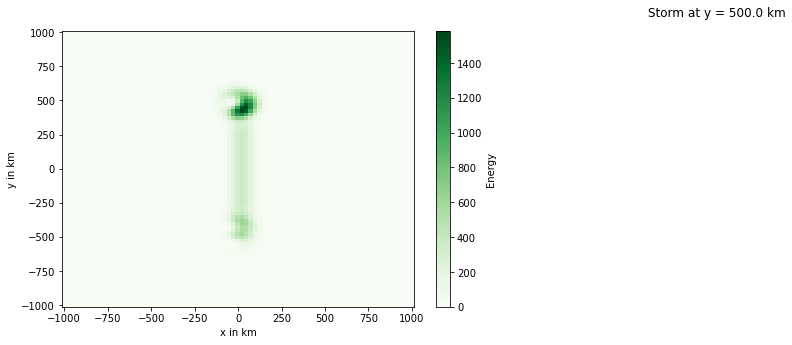

In [15]:
storm.plot_energy()

In [152]:
storm.leap_frog(2000.)

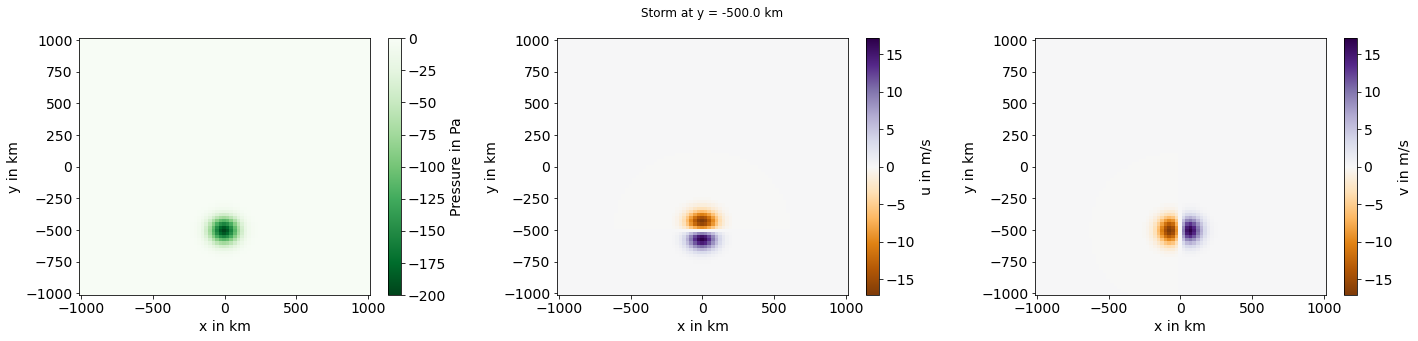

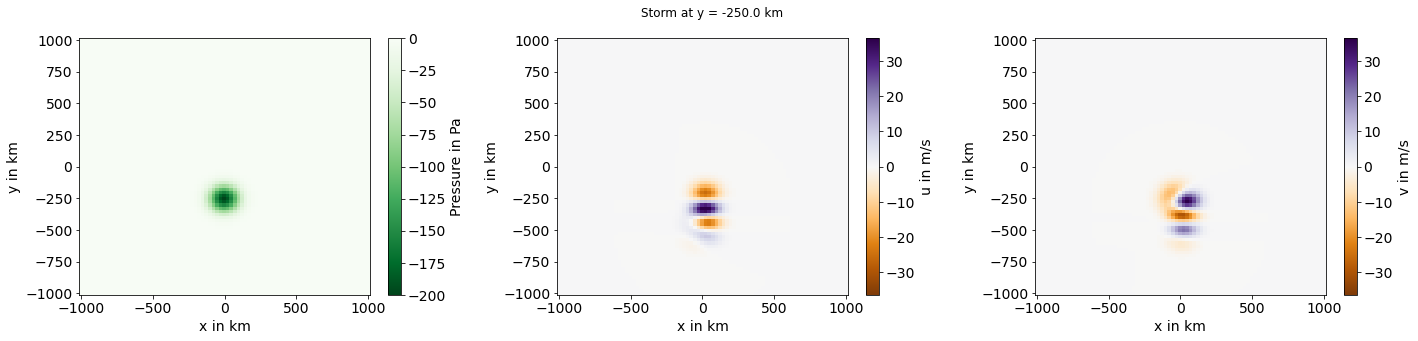

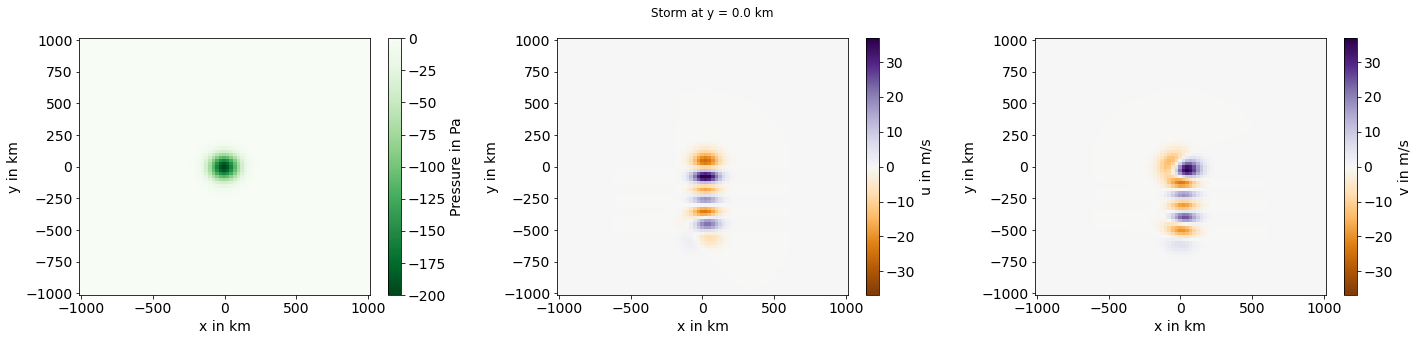

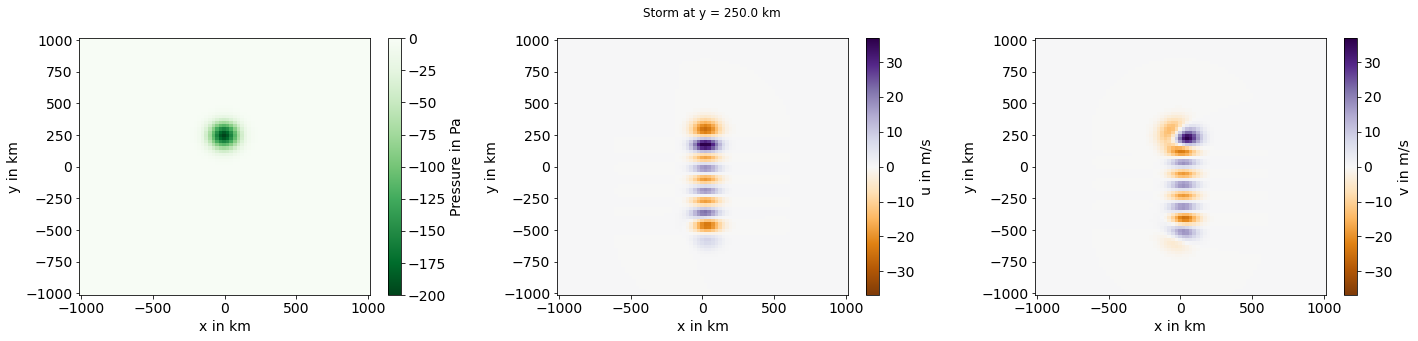

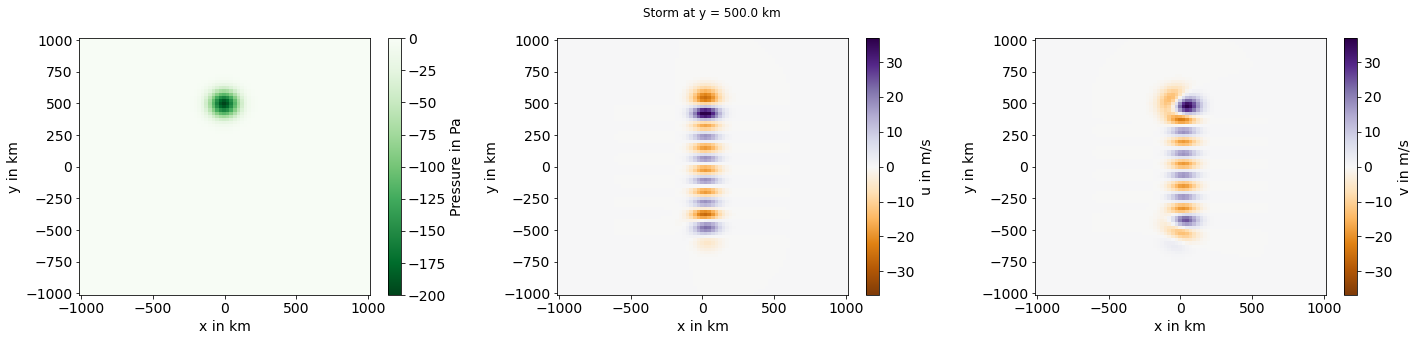

In [153]:
storm.plot()

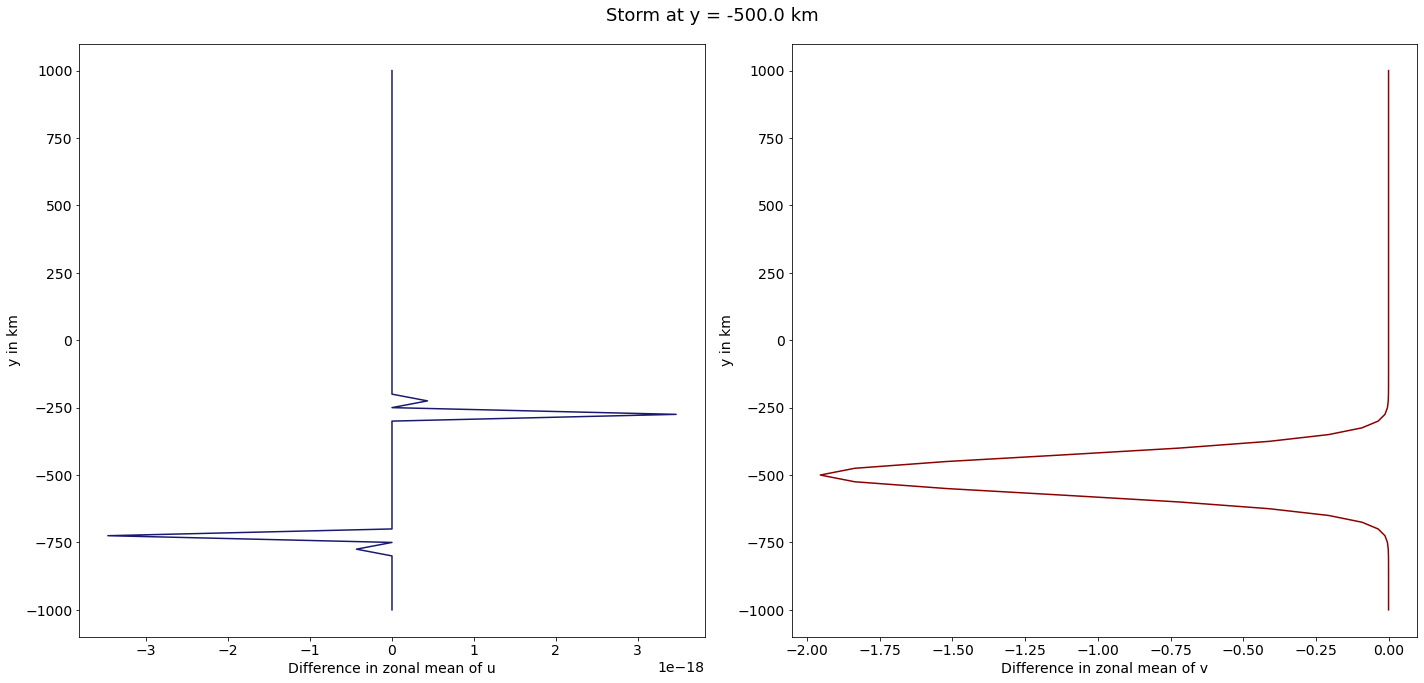

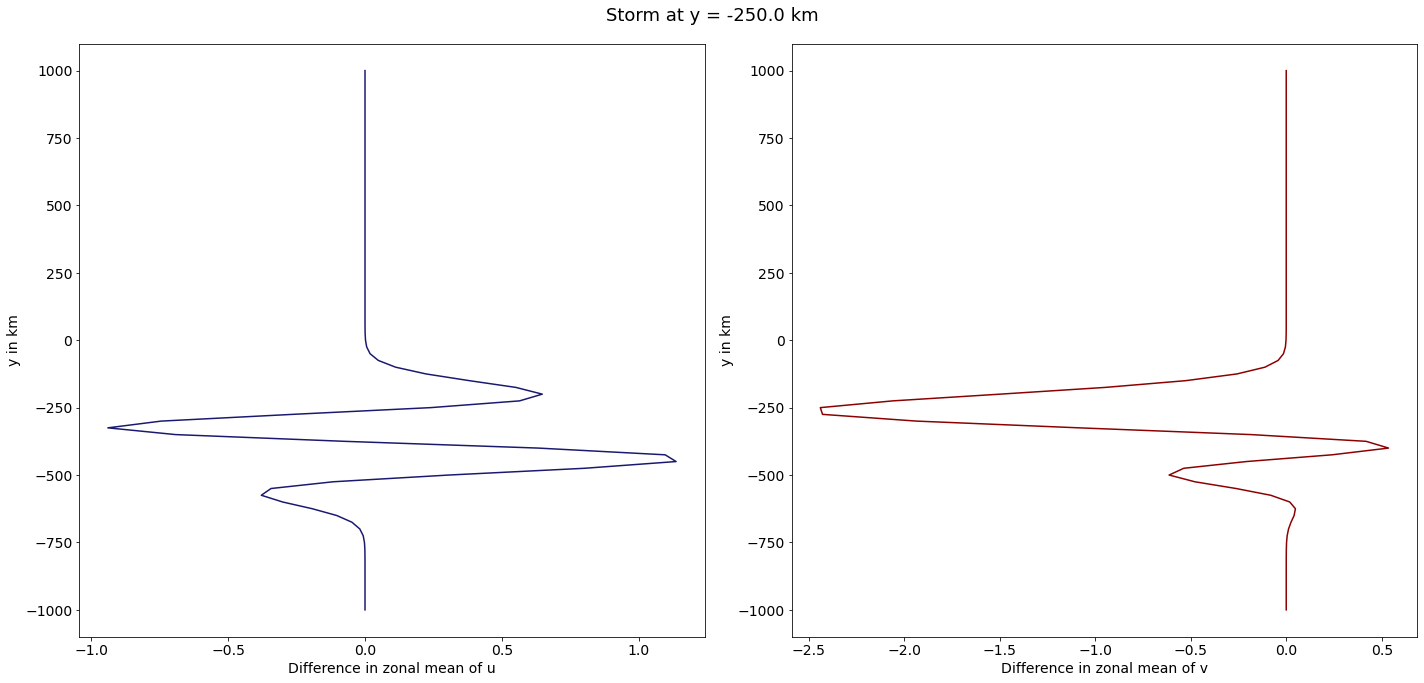

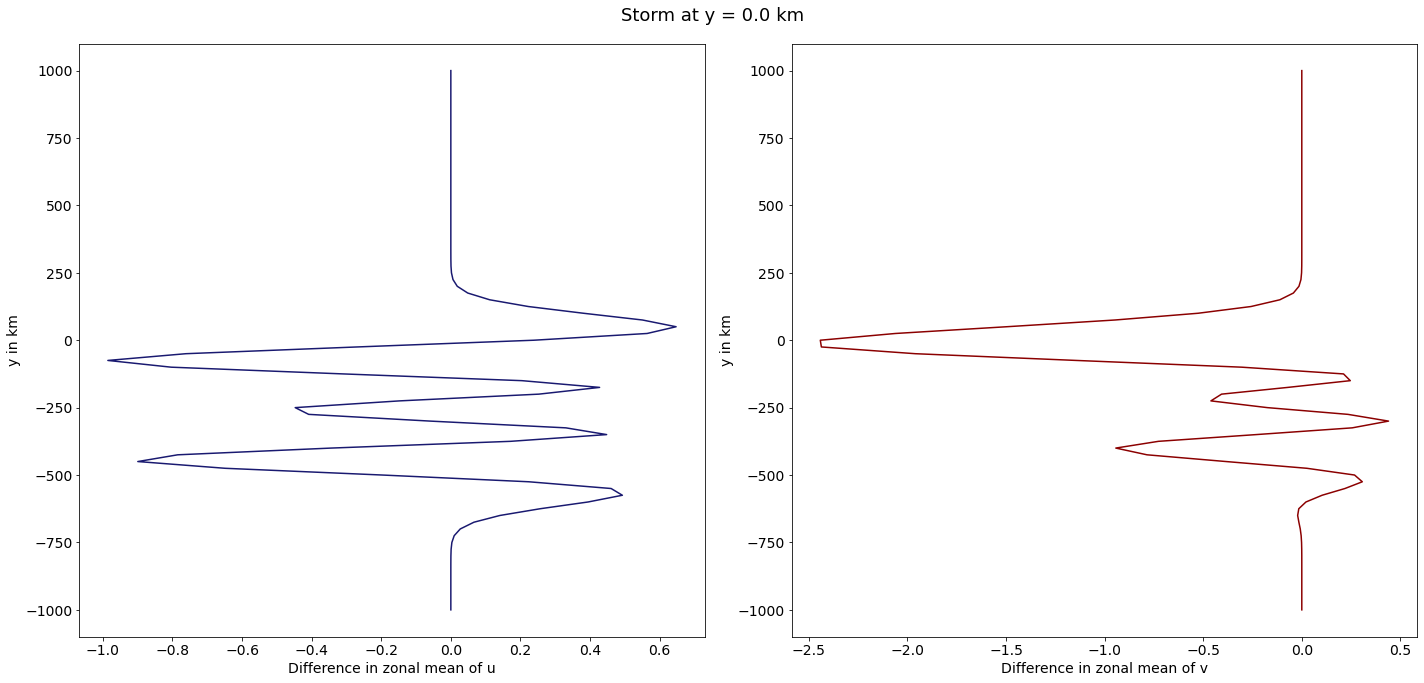

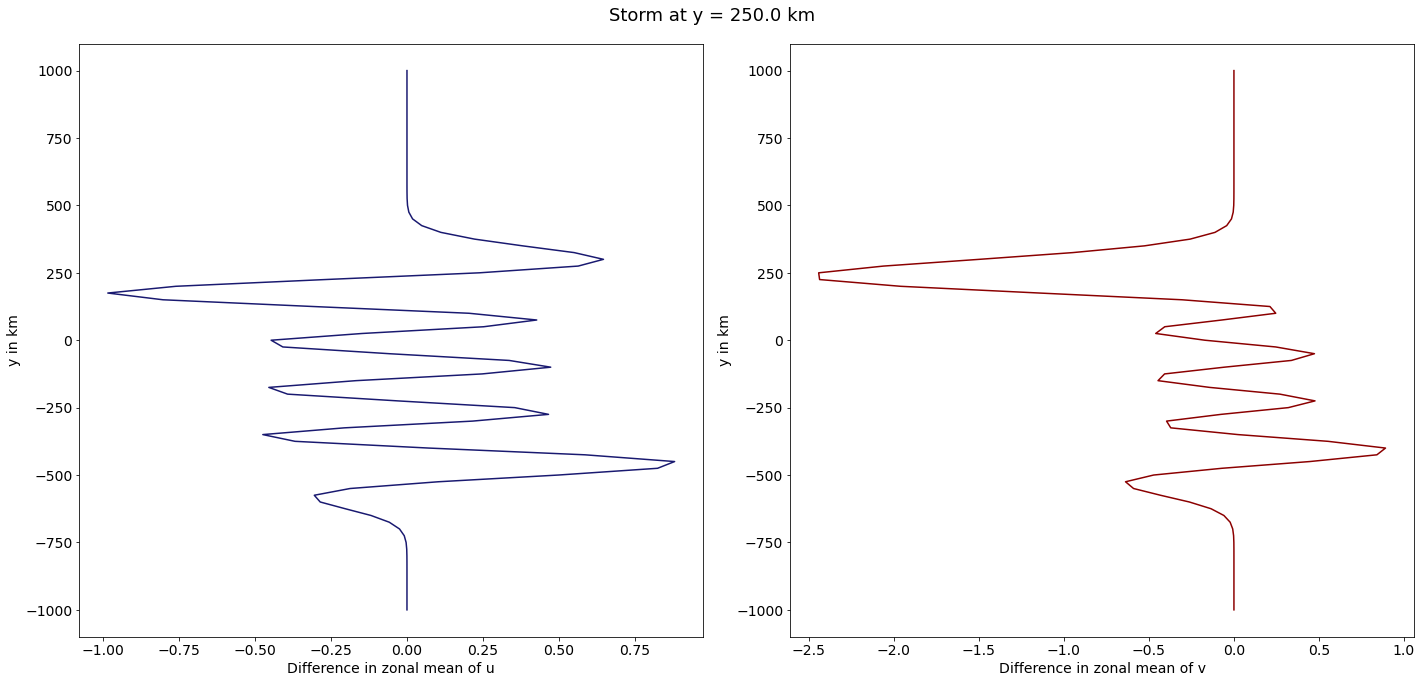

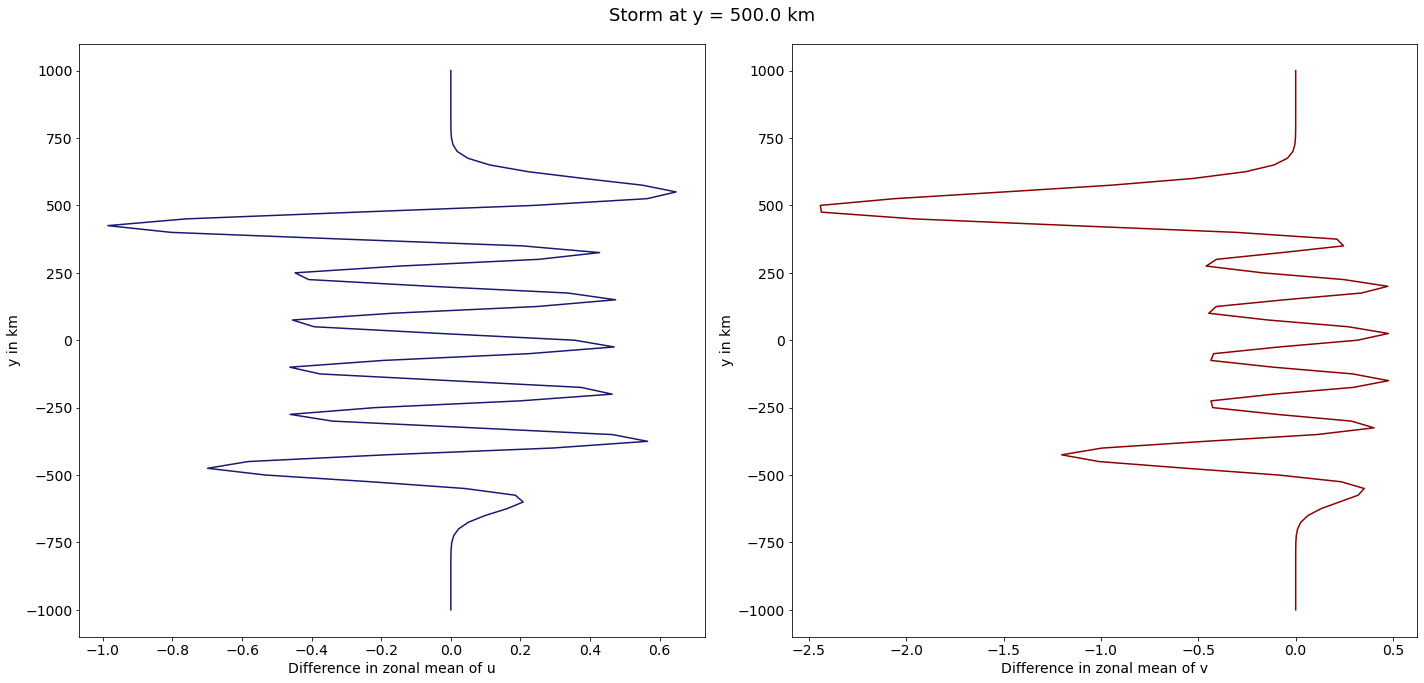

In [154]:
storm.zonal_asymmetry()

In [21]:
average = np.mean(storm.q_out[4].real**2+storm.q_out[4].imag**2,axis=1)

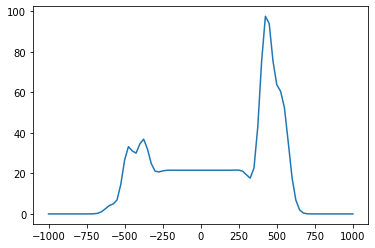

In [22]:
plt.plot(storm.grid_x/1000,average)